In [2]:
import numpy as np
from math import factorial
import matplotlib.pyplot as plt

D_MAX = 8

In [50]:
class ClusterDataset:
    def __init__(self, n=400, d=8) -> None:
        self.n = n
        self.d = d
        self.s = (factorial(d) / factorial(D_MAX)) ** (1 / d)  # Side length of simplex

    def generate_hypercube_points(self, n, d):
        return np.random.uniform(0, 1, size=(n, d))

    def generate_simplex_points(self, n, d, s):
        points = np.random.dirichlet(np.ones(d), size=n)
        return points * s

    def generate(self):
        n_negative = 4 * self.n // 5
        n_positive_simplex = self.n // 10
        n_positive_remaining = self.n // 10

        negative_points = self.generate_hypercube_points(n_negative, self.d)

        positive_simplex_points = self.generate_simplex_points(
            n_positive_simplex, self.d, self.s
        )

        positive_remaining_points = self.generate_hypercube_points(
            n_positive_remaining, self.d
        )

        X = np.vstack(
            (negative_points, positive_simplex_points, positive_remaining_points)
        )
        

        y = np.hstack(
            (np.zeros(n_negative), np.ones(n_positive_simplex + n_positive_remaining))
        )

        return X, y


In [51]:
class TwoClusterDataset:
    def __init__(self, n=400, d=8) -> None:
        self.n = n
        self.d = d
        self.s = (factorial(d) / factorial(D_MAX)) ** (1 / d)  # Side length of simplex

    def generate_hypercube_points(self, n, d):
        return np.random.uniform(0, 1, size=(n, d))

    def generate_simplex_points(self, n, d, s):
        points = np.random.dirichlet(np.ones(d), size=n)
        return points * s

    def generate_diametrically_opposite(self, n, d, s):
        points = np.random.dirichlet(np.ones(d), size=n)
        points = points * s
        return np.ones(d) - points
        
    def generate(self):
        n_negative = 4 * self.n // 5
        n_positive_simplex = self.n // 20
        n_positive_simplex_opp = self.n // 20
        n_positive_remaining = self.n // 10

        negative_points = self.generate_hypercube_points(n_negative, self.d)

        positive_simplex_points = self.generate_simplex_points(
            n_positive_simplex, self.d, self.s
        )
        positive_simplex_points_opp = self.generate_diametrically_opposite(
            n_positive_simplex_opp, self.d, self.s
        )

        positive_remaining_points = self.generate_hypercube_points(
            n_positive_remaining, self.d
        )

        X = np.vstack(
            (negative_points, positive_simplex_points, positive_simplex_points_opp, positive_remaining_points)
        )
        

        y = np.hstack(
            (np.zeros(n_negative), np.ones(n_positive_simplex + n_positive_simplex_opp + n_positive_remaining))
        )

        return X, y

In [52]:
class DiffusedBenchmark:
    def __init__(self, n=400, d=8) -> None:
        self.n = n
        self.d = d

    def generate_hypercube_points(self, n, d):
        return np.random.uniform(0, 1, size=(n, d))

    def generate(self):
        n_negative = self.n // 2
        n_positive = self.n // 2
        
        negative_points = self.generate_hypercube_points(n_negative, self.d)
        positive_points = self.generate_hypercube_points(n_positive, self.d)

        X = np.vstack(
            (negative_points, positive_points)
        )
        

        y = np.hstack(
            (np.zeros(n_negative), np.ones(n_positive))
        )

        return X, y

In [15]:
import numpy as np
from scipy.special import factorial

class PrismDataset:
    def __init__(self, n=400, d=11, f=8, p_mode="P"):
        """
        Parameters:
        n (int): Total number of samples (default: 400).
        d (int): Dimension of the dataset (default: 11).
        f (float): Factor controlling negatives per positive (default: 8).
        p_mode (str): Positive sample mode, "P" (default) or "P/4".
        """
        self.n = n
        self.d = d
        self.f = f
        self.p_mode = p_mode

        # Total number of positive and negative samples
        self.n_positive = n // 33
        self.n_negative = n - self.n_positive

        # Ratio of positives to negatives
        self.p_to_n_ratio = self.n_positive / self.n_negative

        # Volume (v) of the simplex
        self.v = ((self.n_positive if self.p_mode == "P" else self.n_positive / 4) * self.f) / self.n_negative

        # Calculate d0 based on factorial constraints
        self.d0 = self._compute_d0()
        print("self.d0", self.d0)
        

        # Side length of the simplex
        self.s = (self.v * factorial(self.d0)) ** (1 / self.d0)

    def _compute_d0(self):
        """Calculate d0 based on |N| / (p * f)."""
        for d0 in range(1, self.d + 1):
            if factorial(d0) <=  self.n_negative / ((self.n_positive if self.p_mode == "P" else self.n_positive / 4) * self.f):
                continue
            return d0 - 1
        return self.d

    def generate_hypercube_points(self, n, d):
        """Generate points uniformly in a hypercube."""
        return np.random.uniform(0, 1, size=(n, d))

    def generate_prism_points(self, n, d, d0, s):
        """
        Generate points within a d0-dimensional simplex and extend to d dimensions.
        """
        d0 += 1
        simplex_points = np.random.dirichlet(np.ones(d0), size=n) * s
        padding = np.random.uniform(0, 1, size=(n, d - d0))  # Random padding
        return np.hstack((simplex_points, padding))

    def generate(self):
        """
        Generate the Prism dataset.

        Returns:
        X (numpy.ndarray): Feature matrix of shape (n, d).
        y (numpy.ndarray): Labels array of shape (n,).
        dict: Counts of each type of sample.
        """
        # Positive samples
        n_positive_prism = self.n_positive if self.p_mode == "P" else self.n_positive // 4
        n_positive_hypercube = self.n_positive - n_positive_prism

        # Negative samples
        n_negative_prism = int(self.n_negative * self.v)
        n_negative_hypercube = self.n_negative - n_negative_prism

        # Generate samples
        positive_prism_points = self.generate_prism_points(n_positive_prism, self.d, self.d0, self.s)
        positive_hypercube_points = self.generate_hypercube_points(n_positive_hypercube, self.d)

        negative_prism_points = self.generate_prism_points(n_negative_prism, self.d, self.d0, self.s)
        negative_hypercube_points = self.generate_hypercube_points(n_negative_hypercube, self.d)

        # Combine into dataset
        X = np.vstack((negative_prism_points, negative_hypercube_points, positive_prism_points, positive_hypercube_points))
        y = np.hstack((np.zeros(n_negative_prism + n_negative_hypercube), np.ones(n_positive_prism + n_positive_hypercube)))

        # Count of each type
        sample_counts = {
            "positive_in_prism": n_positive_prism,
            "positive_not_in_prism": n_positive_hypercube,
            "negative_in_prism": n_negative_prism,
            "negative_not_in_prism": n_negative_hypercube,
        }

        return X, y, sample_counts


In [4]:
def plot(X, y):
    plt.figure(figsize=(4, 4))
    plt.scatter(
        X[y == 0][:, 0],
        X[y == 0][:, 1],
        color="blue",
        label="Negative Samples",
        alpha=0.5,
        marker='x'
    )
    plt.scatter(
        X[y == 1][:, 0],
        X[y == 1][:, 1],
        color="red",
        label="Positive Samples",
        alpha=0.5,
        marker='x',
    )
    plt.xlabel("Feature 1")
    plt.ylabel("Feature 2")
    plt.legend()
    plt.grid()
    plt.show()

In [55]:
cd = ClusterDataset(400, 4)

In [56]:
X, y = cd.generate()

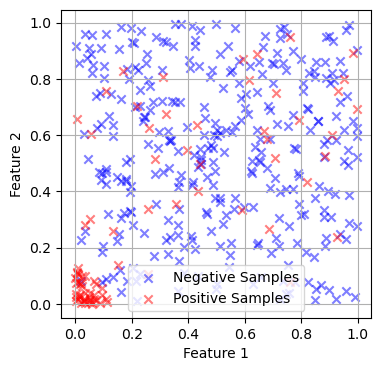

In [57]:
plot(X, y)

In [58]:
(factorial(2) / factorial(8)) ** (1/2)

0.0070429521227376385

In [59]:
tcd = TwoClusterDataset(400, 4)

In [60]:
X_t, y_t = tcd.generate()

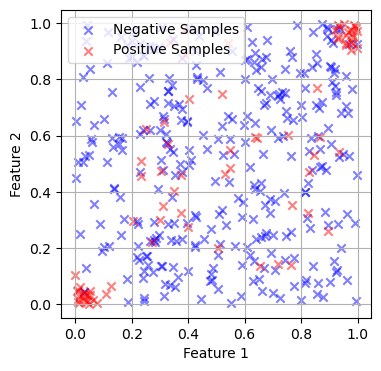

In [61]:
plot(X_t, y_t)

In [62]:
df = DiffusedBenchmark(400, 2)

In [63]:
X_df, y_df = df.generate()

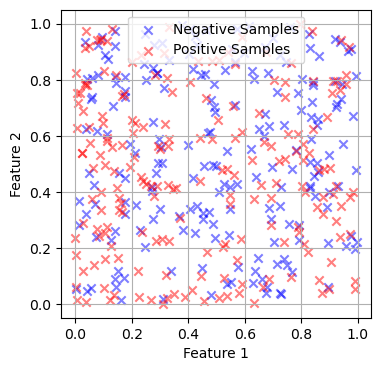

In [64]:
plot(X_df, y_df)

In [16]:
pris = PrismDataset(n=400, p_mode="P")

self.d0 2


In [17]:
X, y, details = pris.generate()

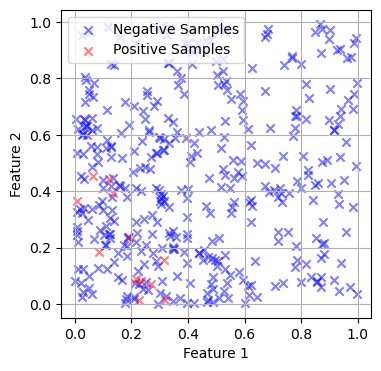

In [18]:
plot(X, y)

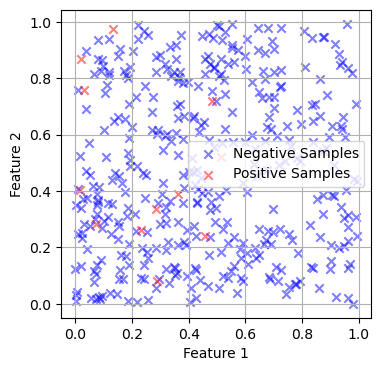

In [12]:

plt.figure(figsize=(4, 4))
plt.scatter(
    X[y == 0][:, 1],
    X[y == 0][:, 2],
    color="blue",
    label="Negative Samples",
    alpha=0.5,
    marker='x'
)
plt.scatter(
    X[y == 1][:, 1],
    X[y == 1][:, 2],
    color="red",
    label="Positive Samples",
    alpha=0.5,
    marker='x',
)
plt.xlabel("Feature 1")
plt.ylabel("Feature 2")
plt.legend()
plt.grid()
plt.show()

In [2]:
# from docplex.mp.model import Model
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import gurobipy as grb

ModuleNotFoundError: No module named 'gurobipy'